--- FÍSICA: Modelo con Hopping J=0.6 (Genera error Trotter) ---
1. Calculando Exacto (Matriz 8x8)...
2. Calculando Cuántico (1 Paso Trotter - Aproximación basta)...
3. Calculando Cuántico (15 Pasos Trotter - Alta precisión)...


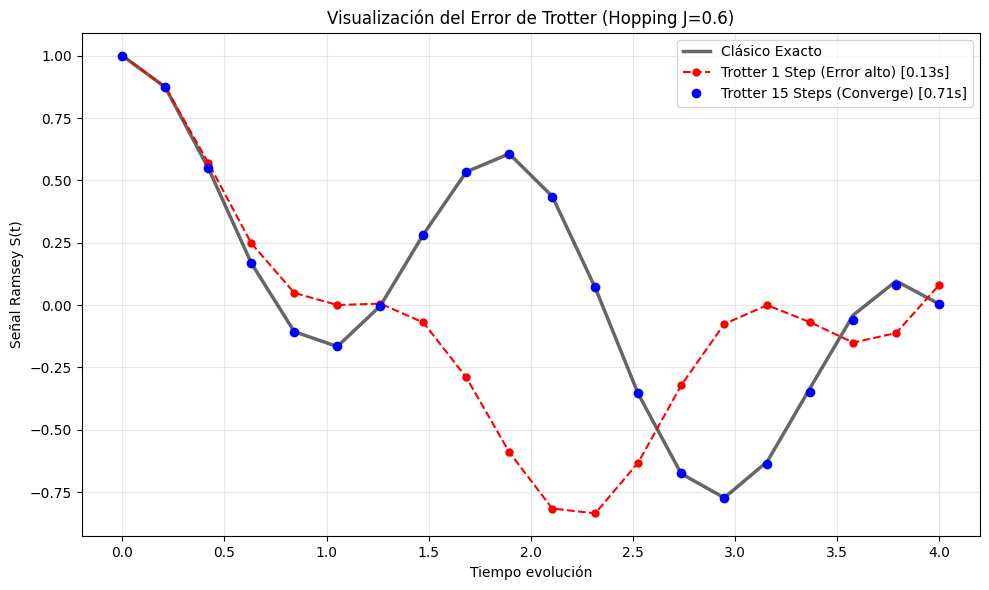

In [2]:
import time
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt

# --- PARÁMETROS FÍSICOS ---
EPS = 0.5       # Energía de sitio
U_FF = 2.0      # Interacción fuerte
U_IMP = 2.0     # Interacción impureza
J_HOP = 0.6     #Término de salto (Tunneling) para causar error de Trotter
T_MAX = 4.0

t_points = np.linspace(0, T_MAX, 20)

# ======================================================
# 1. SOLUCIÓN EXACTA (CLÁSICA MATRICIAL)
# ======================================================
def get_exact_ramsey(t_vals):
    dim = 8
    H = np.zeros((dim, dim))
    
    # Construcción del Hamiltoniano Completo
    for i in range(dim):
        # Bits: 2->Imp, 1->Down, 0->Up
        n_up   = (i >> 0) & 1
        n_down = (i >> 1) & 1
        n_imp  = (i >> 2) & 1
        
        # 1. Diagonal (Energías e Interacciones ZZ)
        E = EPS*(n_up + n_down) + 0.2*n_imp
        E += U_FF * n_up * n_down
        E += U_IMP * n_imp * (n_up + n_down)
        H[i, i] = E
        
        # 2. Off-Diagonal (Tunneling/Hopping en X)
        # Esto hace que Z y X peleen, creando el error de Trotter
        # Flip bit 0 (Up)
        j_up = i ^ 1 
        H[i, j_up] += J_HOP
        # Flip bit 1 (Down)
        j_down = i ^ 2
        H[i, j_down] += J_HOP

    # Estado inicial: 1/sqrt(2) (|000> + |011>)
    psi0 = np.zeros(dim)
    psi0[0] = 1/np.sqrt(2) # |000>
    psi0[3] = 1/np.sqrt(2) # |011> (binary 3 is 011)
    
    # Evolución exacta via diagonalización
    vals, vecs = np.linalg.eigh(H)
    coeffs = vecs.T @ psi0
    
    signal = np.zeros_like(t_vals)
    for k in range(dim):
        # S(t) = Sum |c_k|^2 * cos(E_k * t)
        signal += np.abs(coeffs[k])**2 * np.cos(vals[k] * t_vals)
    return signal

# ======================================================
# 2. SOLUCIÓN CUÁNTICA (VQE/TROTTER)
# ======================================================
def run_quantum_trotter(t_vals, steps):
    # Wires: 0=Ancilla, 1=Up, 2=Down, 3=Impurity
    dev = qml.device("default.qubit", wires=4, shots=None)
    
    @qml.qnode(dev)
    def circuit(time_pt):
        # --- A. PREPARACIÓN DE ESTADO ---
        # Sistema: |00> + |11> en wires 1,2
        qml.Hadamard(wires=1)
        qml.CNOT(wires=[1, 2])
        
        # --- B. RAMSEY INICIO ---
        qml.Hadamard(wires=0) # Ancilla a superposición
        
        # --- C. EVOLUCIÓN TROTTERIZADA CONTROLADA ---
        if time_pt > 0:
            dt = time_pt / steps
            
            for _ in range(steps):
                # IMPORTANTE: El orden importa para el error de Trotter
                
                # 1. Términos Diagonales (Z/Phase) - "Potential Energy"
                # Usamos PhaseShift porque corresponde exactamente a la ocupación 'n' (0 o 1)
                # E = EPS * n
                qml.ctrl(qml.PhaseShift, control=0)(-EPS * dt, wires=1)
                qml.ctrl(qml.PhaseShift, control=0)(-EPS * dt, wires=2)
                
                # E = U * n1 * n2 (ControlledPhase es fase si ambos son 1)
                qml.ctrl(qml.ControlledPhaseShift, control=0)(-U_FF * dt, wires=[1, 2])
                qml.ctrl(qml.ControlledPhaseShift, control=0)(-U_IMP * dt, wires=[3, 1])
                qml.ctrl(qml.ControlledPhaseShift, control=0)(-U_IMP * dt, wires=[3, 2])
                
                # 2. Términos Off-Diagonal (X) - "Kinetic Energy"
                # RX aplica rotación X. H_hop = J * X.
                # Unitario = exp(-i * J * X * t) -> RX(2 * J * t)
                qml.ctrl(qml.RX, control=0)(2 * J_HOP * dt, wires=1)
                qml.ctrl(qml.RX, control=0)(2 * J_HOP * dt, wires=2)
        
        # --- D. RAMSEY FIN ---
        qml.Hadamard(wires=0)
        
        # Probabilidad de P(0) - P(1) es equivalente a medir <Z>
        return qml.probs(wires=0)

    sig = []
    for t in t_vals:
        p = circuit(t)
        sig.append(p[0] - p[1])
    return np.array(sig)

# ======================================================
# 3. EJECUCIÓN Y COMPARATIVA
# ======================================================
print(f"--- FÍSICA: Modelo con Hopping J={J_HOP} (Genera error Trotter) ---")

print("1. Calculando Exacto (Matriz 8x8)...")
y_exact = get_exact_ramsey(t_points)

print("2. Calculando Cuántico (1 Paso Trotter - Aproximación basta)...")
start = time.time()
y_q_bad = run_quantum_trotter(t_points, steps=1)
time_bad = time.time() - start

print("3. Calculando Cuántico (15 Pasos Trotter - Alta precisión)...")
start = time.time()
y_q_good = run_quantum_trotter(t_points, steps=15)
time_good = time.time() - start

# ======================================================
# 4. GRÁFICA PRO
# ======================================================
plt.figure(figsize=(10, 6))

# Exacto (Línea negra sólida)
plt.plot(t_points, y_exact, 'k-', linewidth=2.5, alpha=0.6, label='Clásico Exacto')

# Mal Fit (Rojo discontinua)
plt.plot(t_points, y_q_bad, 'r--o', markersize=5, label=f'Trotter 1 Step (Error alto) [{time_bad:.2f}s]')

# Buen Fit (Azul puntos)
plt.plot(t_points, y_q_good, 'bo', markersize=6, label=f'Trotter 15 Steps (Converge) [{time_good:.2f}s]')

plt.title(f"Visualización del Error de Trotter (Hopping J={J_HOP})")
plt.xlabel("Tiempo evolución")
plt.ylabel("Señal Ramsey S(t)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()